In [3]:
#Also Implement these Ideas: vvvv

# Have many possible starting points. Many starting reward functions. Test if they start to perform.

# This bit will be an exploration of the weaknesses of the architecture, in turn checking robustness.

# This could compose of creating many 'bad' initial reward functions and seeing if it can re-adjust.

# I would also need to investigate the performance changes between changes of reward functions and see over time if this actually improves performance regularly, is it robust over many changes in this sense?


#Effective waiting time.
#Take the current implementation and change it to **measure balance time as a performance metric**

### **Here I am simply investigating the robustness of performance when adapting reward functions**

-> Does the performance have an unexpected jumps? Does the performance drop? Are the reward functions sensible in the context?

I do this in three stages of tests:
1. *Test a badly initilized reward function. See how it adaptively updates.*
2. *Start with good intial composite reward functions, but vary environment states over time. See if it is robust to varying environment variables. This includes a "waiting time" function, which chooses when to alter the composite reward functions.*
3. *Altered pattern of enironment changes from stage 2.*

### **Robustness Definition**
In this experiment I have defined Robustness as a system's ability to:

- Maintain acceptable performance levels during environmental changes
- Adapt its reward function appropriately to new conditions
- Recover from performance drops within a reasonable timeframe


### **Robustness Metric**
- Performance Stability (PS = minPerformance / averagePerformance)
- Recovery Speed (RS = episodesToRecover / maxAcceptableRecovery)
- Adaption Effectiveness (AE = postChangePerformance / preChangePerformance)


In [1]:
# Cell 1: Common Imports and Setup
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime

# plt.style.use('seaborn')
# sns.set_palette("husl")

current_dir = os.getcwd()  
project_root = str(Path(current_dir).parent.parent)
sys.path.append(project_root)

# Initialize environment and device
from AdaptiveRewardFunctionLearning.Prompts.prompts import device, apiKey,modelName

#Cu stomCartPoleEnv
from RLEnvironment.env import CustomCartPoleEnv
#RewardUpdateSystem
from AdaptiveRewardFunctionLearning.RewardGeneration.rewardCritic import RewardUpdateSystem
#DQLearningAgent
from RLEnvironment.training.agent import DQLearningAgent
from RLEnvironment.training.training import trainDQLearning

#DynamicRewardFunction
from AdaptiveRewardFunctionLearning.RewardGeneration.rewardCodeGeneration import dynamicRewardFunction

#import
from AdaptiveRewardFunctionLearning.Visualisation.trainingTestFunctions import (
    runEpisode,
    detectJumps,
    analyzeRewardSensibility,
    performUpdate,
    updateCompositeRewardFunction,
    plotExperimentResults,
    savePlot
)

# Set bad initial reward function
def badReward(observation, action):
    x, xDot, angle, angleDot = observation
    return float(-5.0 * abs(x) + 0.1 * np.cos(angle) - 0.1 * abs(xDot))
    

### **Experiment 1: Bad Initialization Test**

Starting Bad Initialization Test...

Attempting update at episode 100

Generating new reward function for component 1...

Error during update: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'You have reached your specified API usage limits. You will regain access on 2024-12-01 at 00:00 UTC.'}}

Attempting update at episode 200

Generating new reward function for component 1...

Error during update: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'You have reached your specified API usage limits. You will regain access on 2024-12-01 at 00:00 UTC.'}}

Attempting update at episode 300

Generating new reward function for component 1...

Error during update: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'You have reached your specified API usage limits. You will regain access on 2024-12-01 at 00:00 UTC.'}}

Attempting update at episode 400

Generating new reward f

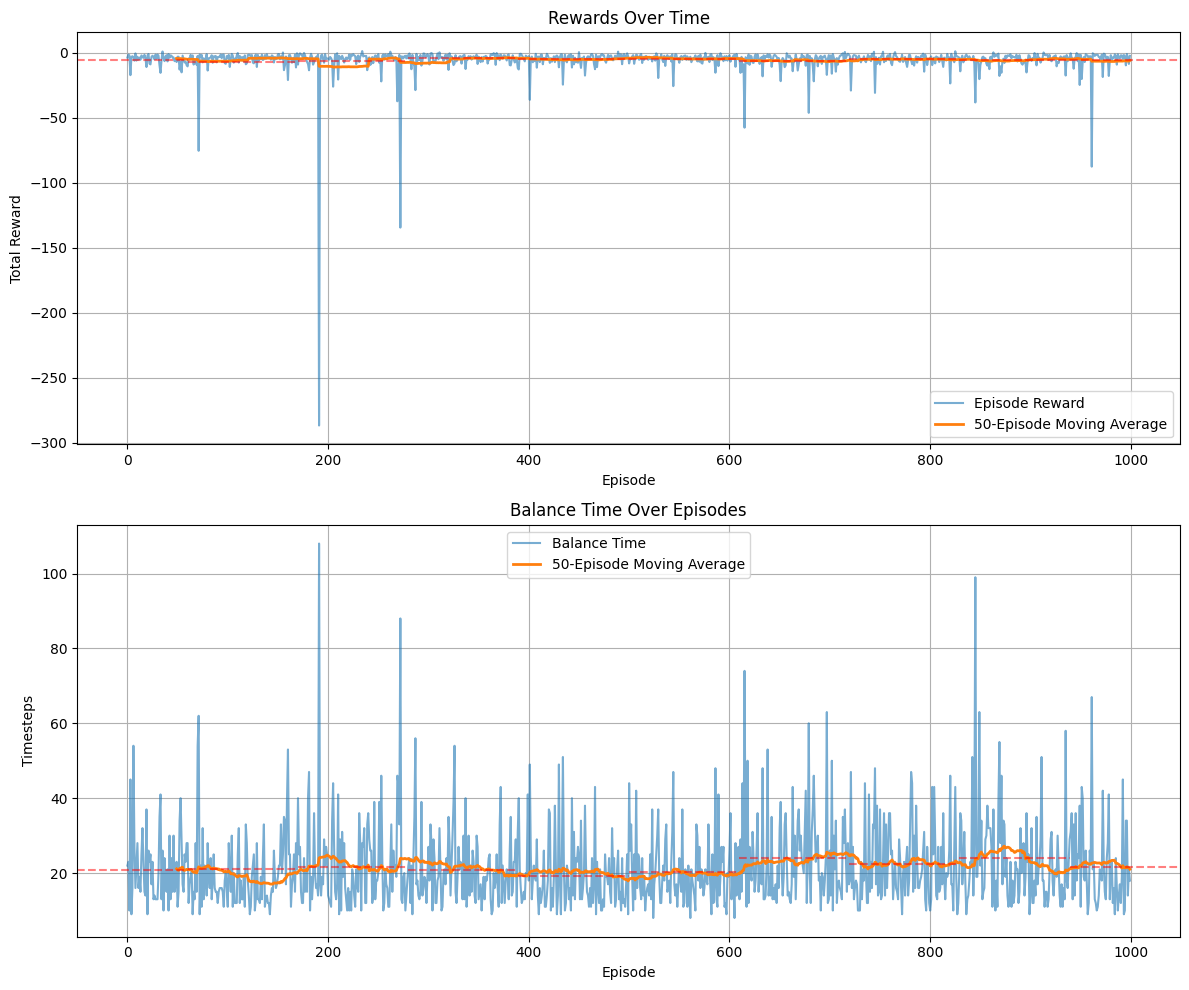

In [2]:
# Cell 2: Experiment 1 - Bad Initialization Test
def runBadInitializationTest(episodes=1000):
    print("Starting Bad Initialization Test...")
    
    env = gym.make('CartPole-v1')


    env = CustomCartPoleEnv(env)
    
    env.setRewardFunction(badReward)

    updateSystem = RewardUpdateSystem(apiKey, modelName)

    agent = DQLearningAgent(env, 4, 2, device)
    
    rewards = []
    balance_times = [] 
    metrics = {}
    rewardChangeEpisodes = []
    

    
    for episode in range(episodes):
        state = env.reset()[0]
        episode_reward = 0
        timesteps = 0 
        done = False

        while not done:
            action = agent.chooseAction(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            timesteps += 1 
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state

        rewards.append(episode_reward)
        balance_times.append(timesteps)
        
        if episode % 100 == 0:
            metrics[episode] = {
                'jumps': detectJumps(rewards),
                'averageReward': np.mean(rewards[-100:]),
                'sensibility': analyzeRewardSensibility(env.rewardFunction),
                'averageBalanceTime': np.mean(balance_times[-100:])
            }
            

        # print("Episode: " + str(episode))
        if updateSystem.waitingTimeConstant(episode, 100):
            if performUpdate(env, updateSystem, episode):  # Check if update happened
                rewardChangeEpisodes.append(episode)

        # rewardChangeEpisodes = updateSystem.getUpdateEpisodes()
    
    # Plot results with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot rewards
    ax1.plot(rewards, alpha=0.6, label='Episode Reward')
    ax1.plot(pd.Series(rewards).rolling(50).mean(), label='50-Episode Moving Average', linewidth=2)

    # Add horizontal lines for reward averages
    for i in range(0, len(rewards), 100):
        avg_reward = np.mean(rewards[i:i+100])
        ax1.axhline(y=avg_reward, xmin=i/len(rewards), xmax=(i+100)/len(rewards), 
                color='r', linestyle='--', alpha=0.5)

    # Add vertical lines for reward function changes in reward plot
    for ep in rewardChangeEpisodes:
        ax1.axvline(x=ep, color='g', linestyle='--', alpha=0.3,
                label='Reward Update' if ep == rewardChangeEpisodes[0] else None)

    ax1.set_title('Rewards Over Time')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    ax1.grid(True)

    # Plot balance times
    ax2.plot(balance_times, alpha=0.6, label='Balance Time')
    ax2.plot(pd.Series(balance_times).rolling(50).mean(), label='50-Episode Moving Average', linewidth=2)

    # Add horizontal lines for balance time averages
    for i in range(0, len(balance_times), 100):
        avg_time = np.mean(balance_times[i:i+100])
        ax2.axhline(y=avg_time, xmin=i/len(balance_times), xmax=(i+100)/len(balance_times), 
                color='r', linestyle='--', alpha=0.5)

    # Add vertical lines for reward function changes in balance time plot
    for ep in rewardChangeEpisodes:
        ax2.axvline(x=ep, color='g', linestyle='--', alpha=0.3,
                label='Reward Update' if ep == rewardChangeEpisodes[0] else None)

    ax2.set_title('Balance Time Over Episodes')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Timesteps')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()

    savePlot(fig, "BadInitialization","RobustnessResults", plotType="training_results")

    plt.show()
    
    return rewards, metrics, balance_times

rewards, metrics, balance_times = runBadInitializationTest(1000)  

### **Experiment 2 - Environment Variation Test**


All relationships connections can be shown mathematically. So if I can show that it can optimally adapt for change in one environment variable it should abstract to other environment changes also

In [ ]:
def runEnvironmentVariationTest(episodes=1000, changeInterval=200,length_changes=[0.5, 1, 1.5, 2, 2.5]):
    print("Starting Environment Variation Test...")
    
    # Define length changes (5 values)
    
    current_length_idx = 0
    
    # Setup environment with initial configuration
    env = gym.make('CartPole-v1')
    env = CustomCartPoleEnv(env)
    env.setEnvironmentParameters(masscart=1.0, length=length_changes[0], gravity=9.8)


    # Initialize update system and agent
    updateSystem = RewardUpdateSystem(apiKey, modelName)
    agent = DQLearningAgent(env, 4, 2, device)
    
    # Initialize metrics and tracking variables
    metrics = {}
    episode_rewards = []
    episode_balance_times = []
    reward_change_episodes = []  # Track reward function changes
    
    # Create callback for length changes
    def onEpisodeEnd(env, updateSystem, episode, reward, steps):
        nonlocal current_length_idx, episode_rewards, episode_balance_times, reward_change_episodes
    
        # Record reward and balance time
        episode_rewards.append(reward)
        episode_balance_times.append(steps)
        
        # Build metrics for composite reward update check
        metrics = {
            'currentEpisode': episode,
            'recentRewards': episode_rewards[-100:] if len(episode_rewards) > 100 else episode_rewards,
            'averageBalanceTime': np.mean(episode_balance_times[-100:]) if episode_balance_times else 0,
            'balanceTimeVariance': np.var(episode_balance_times[-100:]) if len(episode_balance_times) > 1 else 0
        }
        
        # Check for composite reward updates
        updateCompositeRewardFunction(env, updateSystem, metrics, dynamicRewardFunction)
        
        # Check if any composite reward function was updated
        if hasattr(dynamicRewardFunction, 'compositeHistory'):
            latest_updates = [
                update['episode'] for update in dynamicRewardFunction.compositeHistory 
                if update['episode'] == episode
            ]
            if latest_updates:
                reward_change_episodes.append(episode)
                print(f"\nReward function updated at episode {episode}")
        
        if episode % changeInterval == 0 and episode > 0:
            current_length_idx = (current_length_idx + 1) % len(length_changes)
            new_length = length_changes[current_length_idx]
            env.setEnvironmentParameters(length=new_length)
            print(f"\nChanged pole length to: {new_length}m at episode {episode}")
        
        # Record metrics every 50 episodes (for display purposes only)
        if episode % 50 == 0:
            metrics[episode] = {
                'jumps': detectJumps(episode_rewards),
                'averageReward': np.mean(episode_rewards[-100:]) if episode_rewards else 0,
                'sensibility': analyzeRewardSensibility(env.rewardFunction),
                'averageBalanceTime': np.mean(episode_balance_times[-100:]) if episode_balance_times else 0,
                'currentLength': length_changes[current_length_idx]
            }
            print(f"Episode {episode}: Avg Balance Time = {metrics[episode]['averageBalanceTime']:.2f}")
    
    # Train the agent
    agent, env, rewards = trainDQLearning(
        agent=agent,
        env=env,
        numEpisodes=episodes,
        updateSystem=updateSystem,
        onEpisodeEnd=lambda env, updateSystem, episode, reward, steps: onEpisodeEnd(env, updateSystem, episode, reward, steps)
    )
    
    # Create length history
    length_history = []
    for episode in range(episodes):
        idx = (episode // changeInterval) % len(length_changes)
        length_history.append(length_changes[idx])
    
    # Plot results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot rewards
    ax1.plot(episode_rewards, alpha=0.6, label='Episode Reward')
    ax1.plot(pd.Series(episode_rewards).rolling(50).mean(), 
             label='50-Episode Moving Average', linewidth=2)
    
    # Add vertical lines for length changes (red)
    for ep in range(changeInterval, episodes, changeInterval):
        ax1.axvline(x=ep, color='r', linestyle='--', alpha=0.3, 
                   label='Length Change' if ep == changeInterval else None)
    
    # Add vertical lines for reward function changes (green)
    for ep in reward_change_episodes:
        ax1.axvline(x=ep, color='g', linestyle='--', alpha=0.3, 
                   label='Reward Update' if ep == reward_change_episodes[0] else None)
    
    ax1.set_title('Rewards Over Time with Length and Reward Function Changes')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    ax1.grid(True)
    
    # Plot balance times
    ax2.plot(episode_balance_times, alpha=0.6, label='Balance Time')
    ax2.plot(pd.Series(episode_balance_times).rolling(50).mean(), 
             label='50-Episode Moving Average', linewidth=2)
    
    # Add vertical lines for length changes (red)
    for ep in range(changeInterval, episodes, changeInterval):
        ax2.axvline(x=ep, color='r', linestyle='--', alpha=0.3,
                   label='Length Change' if ep == changeInterval else None)
    
    # Add vertical lines for reward function changes (green)
    for ep in reward_change_episodes:
        ax2.axvline(x=ep, color='g', linestyle='--', alpha=0.3,
                   label='Reward Update' if ep == reward_change_episodes[0] else None)
    
    ax2.set_title('Balance Time Over Episodes')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Timesteps')
    ax2.legend()
    ax2.grid(True)
    
    # Plot pole length changes
    ax3.plot(length_history, label='Pole Length')
    ax3.set_title('Pole Length Over Episodes')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Length (m)')
    ax3.grid(True)
    
    plt.tight_layout()
    
    savePlot(fig, "robustnessAnalysis", "RobustnessExperiment2")
    plt.close()
    
    print("\nExperiment completed!")
    
    return {
        'rewards': episode_rewards,
        'balance_times': episode_balance_times,
        'metrics': metrics,
        'length_history': length_history,
        'reward_changes': reward_change_episodes
    }

if __name__ == "__main__":
    results = runEnvironmentVariationTest(10000, 2000, length_changes=[0.5, 0.75, 1.0, 1.25, 1.5] )# Pole lengths in meters
    
    # Print final performance statistics
    final_avg_reward = np.mean(results['rewards'][-100:])
    final_avg_balance = np.mean(results['balance_times'][-100:])
    print(f"\nFinal performance:")
    print(f"Average Reward: {final_avg_reward:.2f}")
    print(f"Average Balance Time: {final_avg_balance:.2f}")

Starting Environment Variation Test...
Environment parameters updated: masscart=1.0, length=0.5, gravity=9.8
Episode 0: Avg Balance Time = 36.00
Episode 50: Avg Balance Time = 25.57
Episode 100: Avg Balance Time = 23.45
Episode 150: Avg Balance Time = 19.30

Checking stability component:
Time since update: 200
Short-term trend: -4.440
Medium-term trend: -1.460
Performance variance: 1159.597

Checking efficiency component:
Time since update: 200
Short-term trend: -4.440
Medium-term trend: -1.460
Performance variance: 1159.597

Checking time component:
Time since update: 200
Short-term trend: -4.440
Medium-term trend: -1.460
Performance variance: 1159.597
Environment parameters updated: masscart=1.0, length=0.75, gravity=9.8

Changed pole length to: 0.75m at episode 200
Episode 200: Avg Balance Time = 28.45

Checking stability component:
Time since update: 201
Short-term trend: -3.839
Medium-term trend: -0.498
Performance variance: 142.688

Checking efficiency component:
Time since updat

### **Experiment 3 -**

Potential Improvments
- Different Sequences of pole lengths
- Testing with different initial conditions (Poor composite reward functions)
- Add robustness metrics

Considering Adding:
- Confidence intervals for robustness metrics (Most papers only really seem to go this far)
- Statistical significance tests between different approaches
- Variance analysis across multiple runs

In [ ]:
if __name__ == "__main__":
    results = runEnvironmentVariationTest(10000, 2000, length_changes=[0.5, 6.4, 5, 1.25, 9.5] )# Pole lengths in meters
    
    # Print final performance statistics
    final_avg_reward = np.mean(results['rewards'][-100:])
    final_avg_balance = np.mean(results['balance_times'][-100:])
    print(f"\nFinal performance:")
    print(f"Average Reward: {final_avg_reward:.2f}")
    print(f"Average Balance Time: {final_avg_balance:.2f}")

: 